In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import scipy.io
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Do we have access to a GPU? Sanity Check
device_list = tf.config.list_physical_devices()
if "GPU" in [device.device_type for device in device_list]:
  print(f"[INFO] TensorFlow has GPU available to use. Woohoo!! Computing will be sped up!")
  print(f"[INFO] Accessible devices:\n{device_list}")
else:
  print(f"[INFO] TensorFlow does not have GPU available to use. Models may take a while to train.")
  print(f"[INFO] Accessible devices:\n{device_list}")

[INFO] TensorFlow has GPU available to use. Woohoo!! Computing will be sped up!
[INFO] Accessible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
import os
path = '/kaggle/input/prune-dataset/Dog_Dataset/images/Images/'
len(os.listdir(path))

120

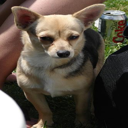

In [4]:
from PIL import Image

im =Image.open('/kaggle/input/prune-dataset/Dog_Dataset/images/Images/n02085620-Chihuahua/n02085620_10074.jpg').resize((128,128))
im

In [6]:
dogs_labels = set()

    
for d in os.listdir(path):
    dogs_labels.add(d)

In [7]:
len(dogs_labels)

120

In [9]:
dogs_labels = list(dogs_labels)
dogs_labels_path = [path + s for s in dogs_labels]

In [26]:
import cv2
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [27]:
X = []
y = []

for type_path, label in zip(dogs_labels_path,dogs_labels) :
    for image_path in os.listdir(type_path):
        image = load_and_preprocess_image(type_path+"/"+image_path)
        
        X.append(image)
        y.append(label)

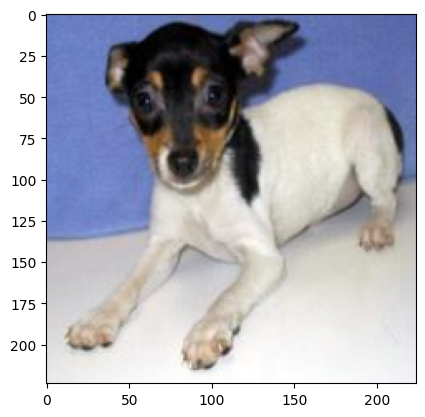

In [28]:
import matplotlib.pyplot as plt
plt.imshow(X[1000])

In [29]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np
encoder = LabelBinarizer()

X = np.array(X)
y = encoder.fit_transform(np.array(y))

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, shuffle=True)

In [17]:
#print(X_train[:10])

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
base_model=VGG16(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(256,activation='relu')(x)
preds=Dense(len(dogs_labels),activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:-5]:
    layer.trainable=False
for layer in model.layers[-5:]:
    layer.trainable=True
    
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])

print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 15,926,968 (60.76 MB)

 Trainable params: 686,968 (2.62 MB)

 Non-trainable params: 15,240,000 (58.14 MB)

None


In [33]:
#from tensokeras.callbacks import ModelCheckpoint,EarlyStopping
#from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
checkpoint = ModelCheckpoint(
    './base.model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
)
earlystop = EarlyStopping(patience=10, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=10,verbose=1)

In [34]:
"""history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint,earlystop, reduce_lr]
)"""
history = model.fit(X_train,y_train,batch_size=64,epochs=50,validation_data=(X_test,y_test), callbacks=[checkpoint,earlystop, reduce_lr])

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.0308 - loss: 5.3055
Epoch 1: val_loss improved from inf to 2.93791, saving model to ./base.model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 122s 424ms/step - accuracy: 0.0310 - loss: 5.3017 - val_accuracy: 0.2257 - val_loss: 2.9379 - learning_rate: 0.0010
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2170 - loss: 3.0146
Epoch 2: val_loss improved from 2.93791 to 2.27686, saving model to ./base.model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 80s 347ms/step - accuracy: 0.2172 - loss: 3.0140 - val_accuracy: 0.3697 - val_loss: 2.2769 - learning_rate: 0.0010
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.3079 - loss: 2.5322
Epoch 3: val_loss improved from 2.27686 to 2.09711, saving model to ./base.model.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 355ms/step - accuracy: 0.3080 - loss: 2.5321 - val_accuracy: 0.4043 - val_loss: 2.0971 - learning_rate: 0.0010
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 287

In [35]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

loss on the test set is 1.68
accuracy on the test set is 0.516


In [36]:
predictions = model.predict(X_test)

115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step


In [37]:
label_predictions = encoder.inverse_transform(predictions)

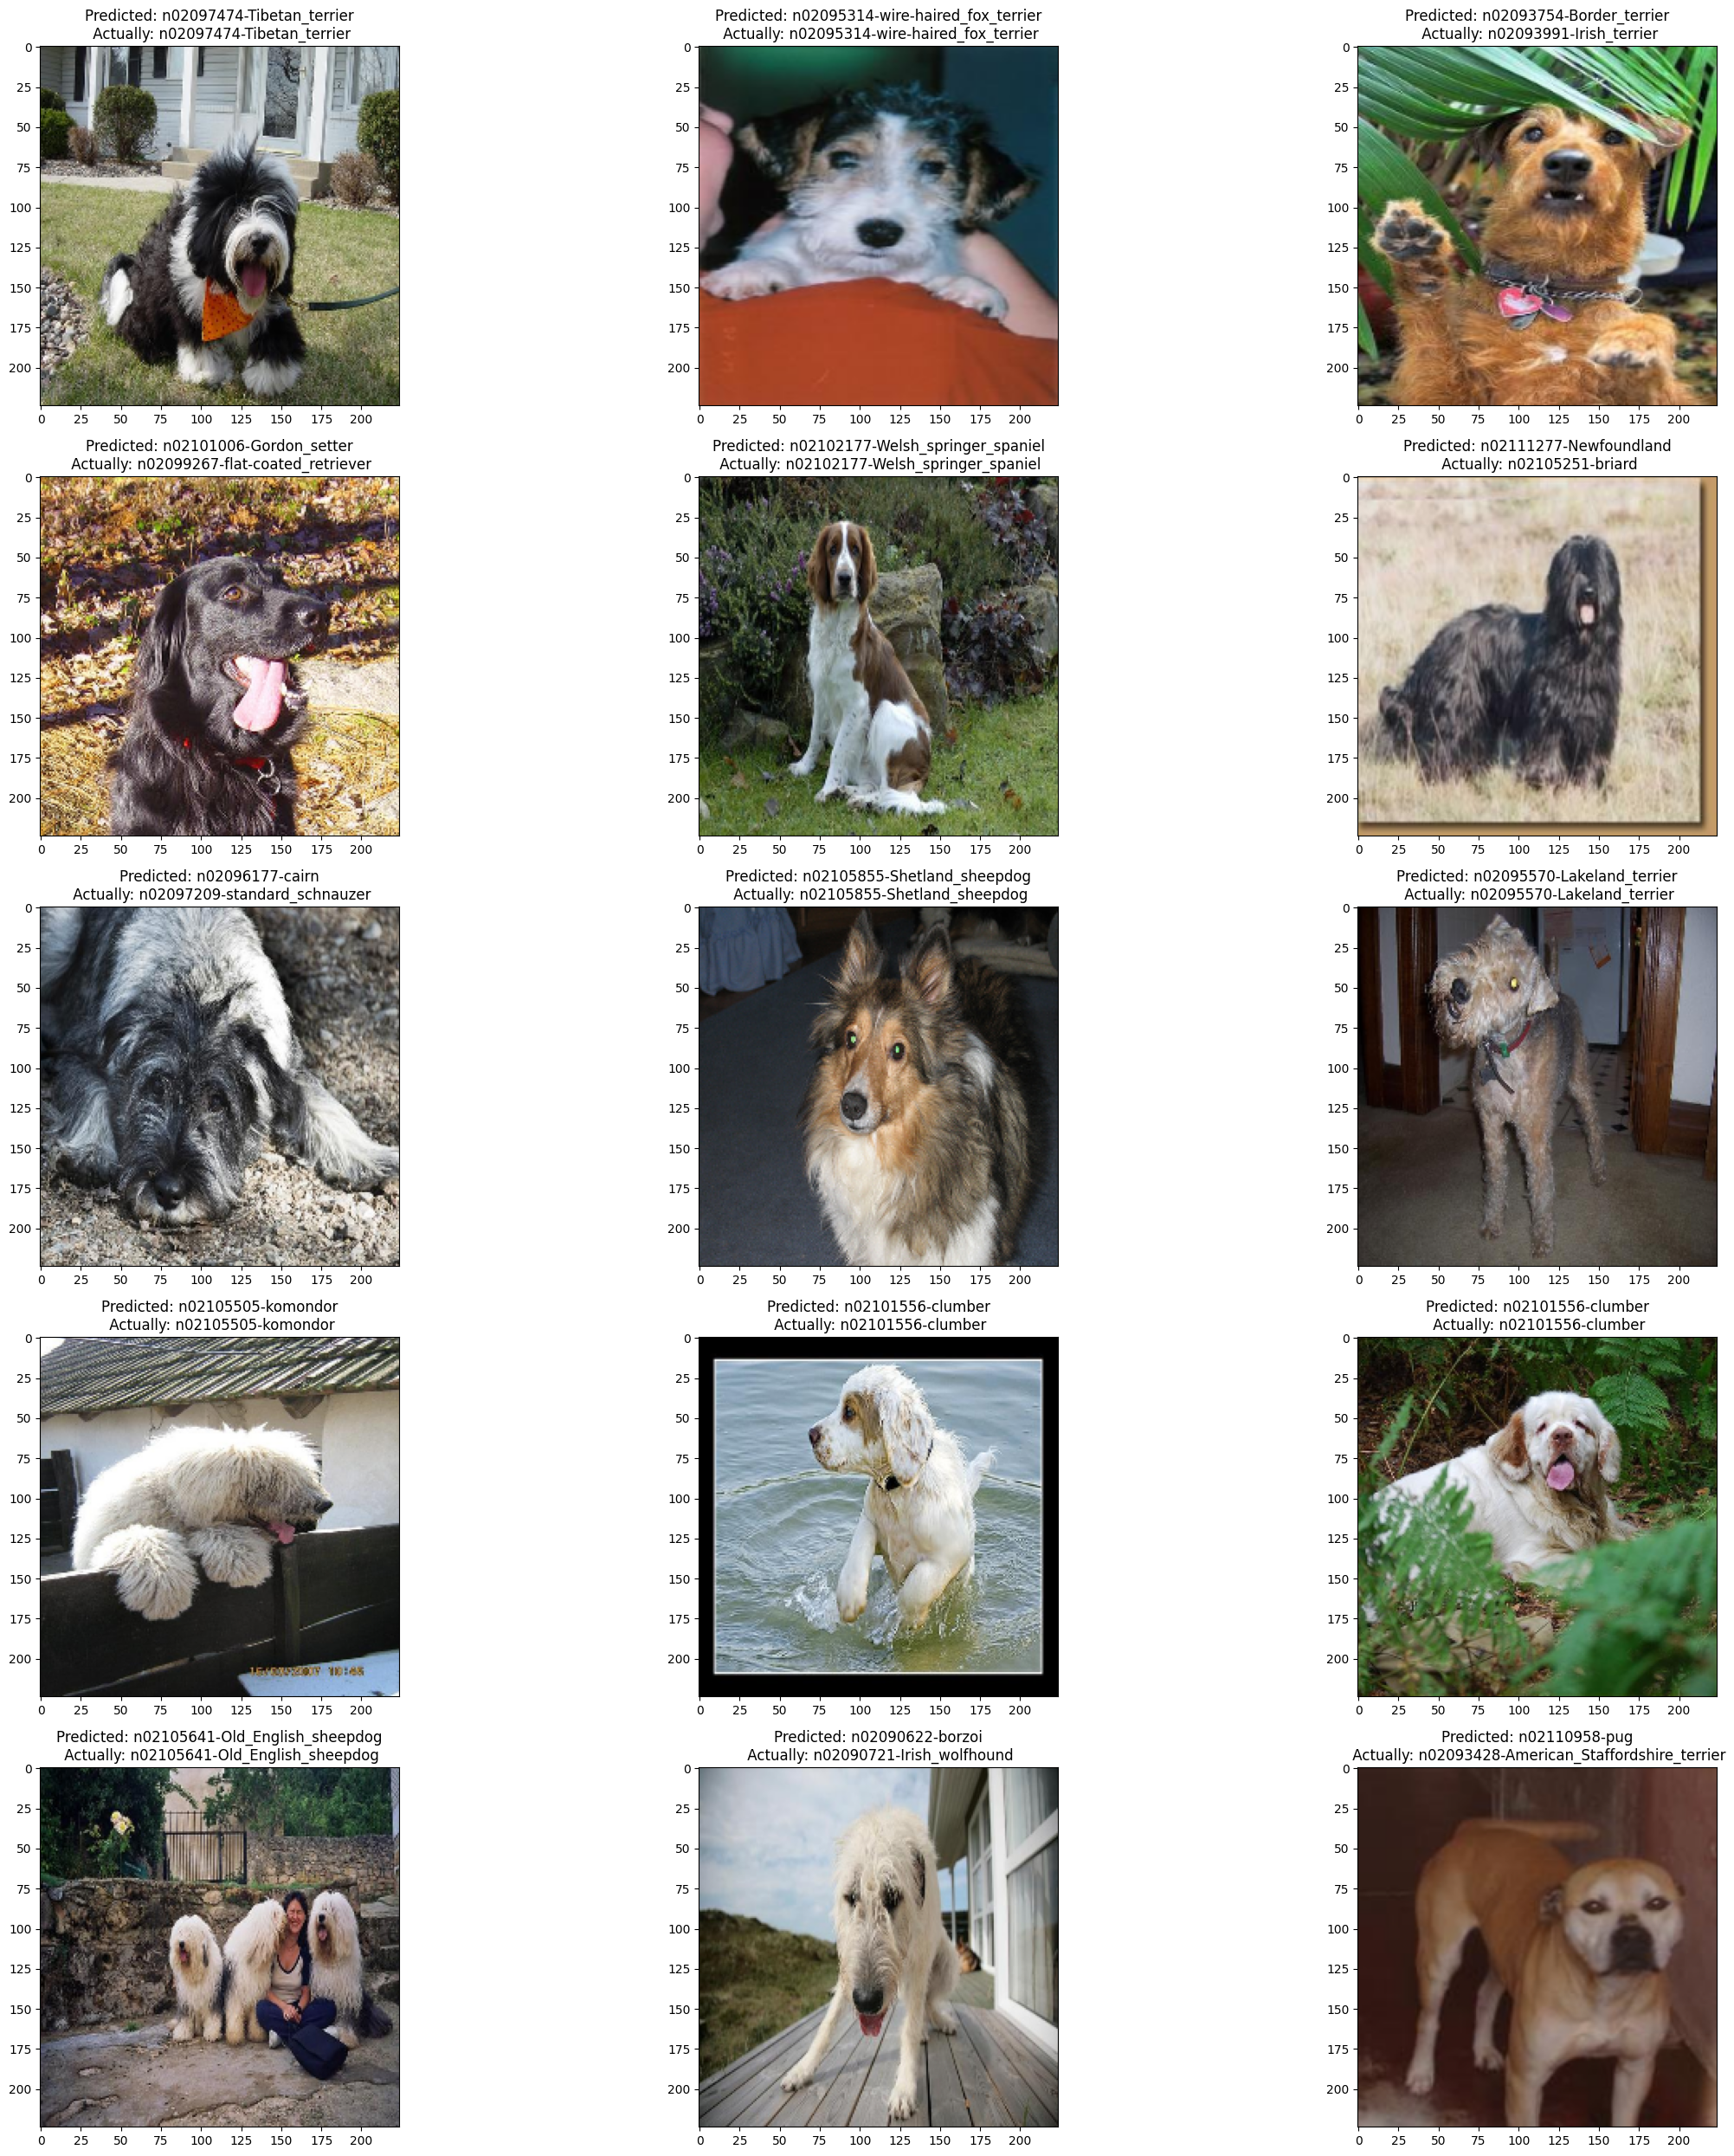

In [38]:
rows, cols = 5, 3
size = 25

fig,ax=plt.subplots(rows,cols)
fig.set_size_inches(size,size)
for i in range(rows):
    for j in range (cols):
        index = np.random.randint(0,len(X_test))
        ax[i,j].imshow(X_test[index])
        ax[i,j].set_title(f'Predicted: {label_predictions[index]}\n Actually: {encoder.inverse_transform(y_test)[index]}')
        
plt.tight_layout()

115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.5076 - loss: 1.6945


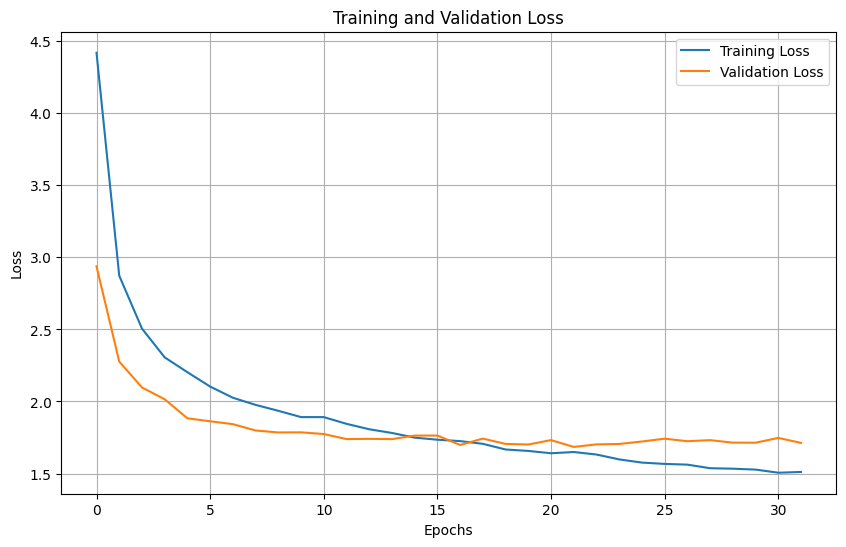

In [39]:
import matplotlib.pyplot as plt
model.evaluate(X_test, y_test)
# Extract loss values from the history object
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step


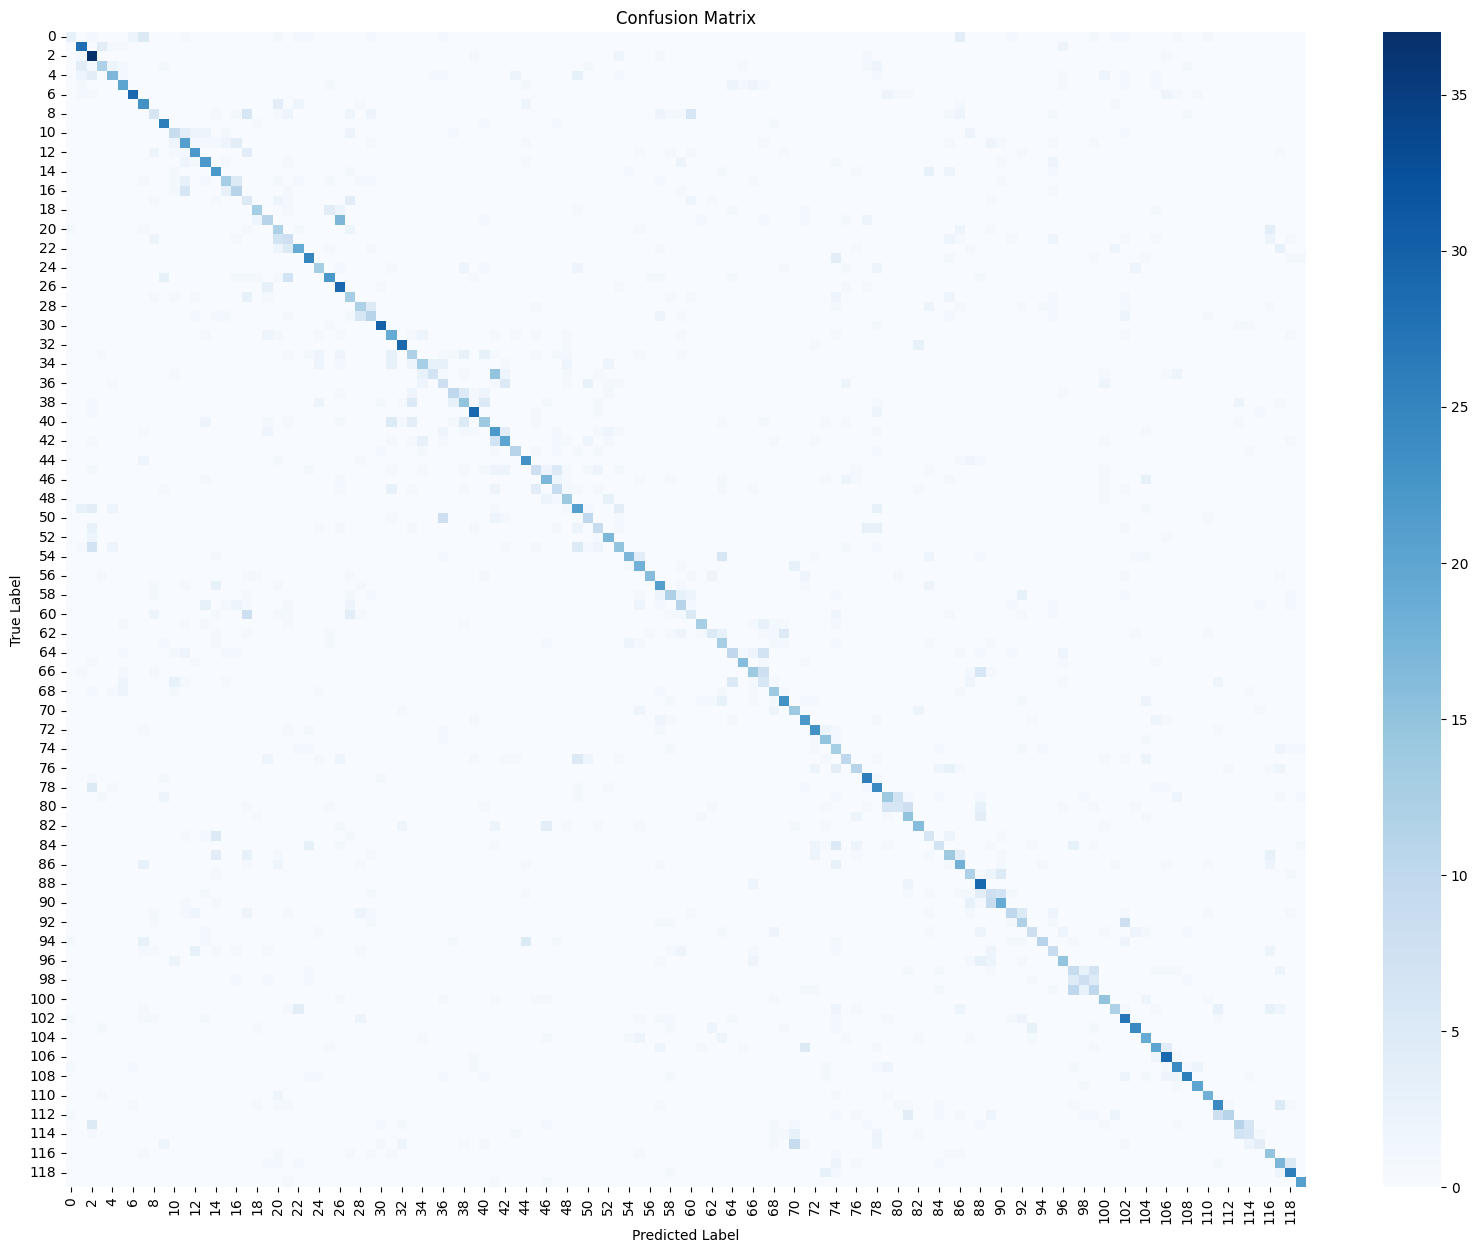

In [41]:
# Create a confusion matrix
# Assuming model predictions and true labels are available
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

conf_matrix = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(20, 15))  # Adjust figsize for better visibility with 120 classes
sns.heatmap(conf_matrix, annot=False, cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [42]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Print classification report for precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.11      0.17        27
           1       0.67      0.78      0.72        36
           2       0.47      0.84      0.61        44
           3       0.57      0.44      0.50        27
           4       0.63      0.45      0.52        38
           5       0.67      0.62      0.65        32
           6       0.88      0.74      0.81        39
           7       0.52      0.68      0.59        34
           8       0.29      0.17      0.21        36
           9       0.70      0.87      0.78        30
          10       0.38      0.38      0.38        24
          11       0.46      0.51      0.48        41
          12       0.65      0.61      0.63        36
          13       0.56      0.65      0.60        34
          14       0.49      0.67      0.56        33
          15       0.54      0.41      0.46        32
          16       0.39      0.46      0.42        24
    

In [43]:
# Plot ROC AUC curve
n_classes = y_test.shape[1]  # Number of classes
y_test_binarized = label_binarize(y_true, classes=np.arange(n_classes))

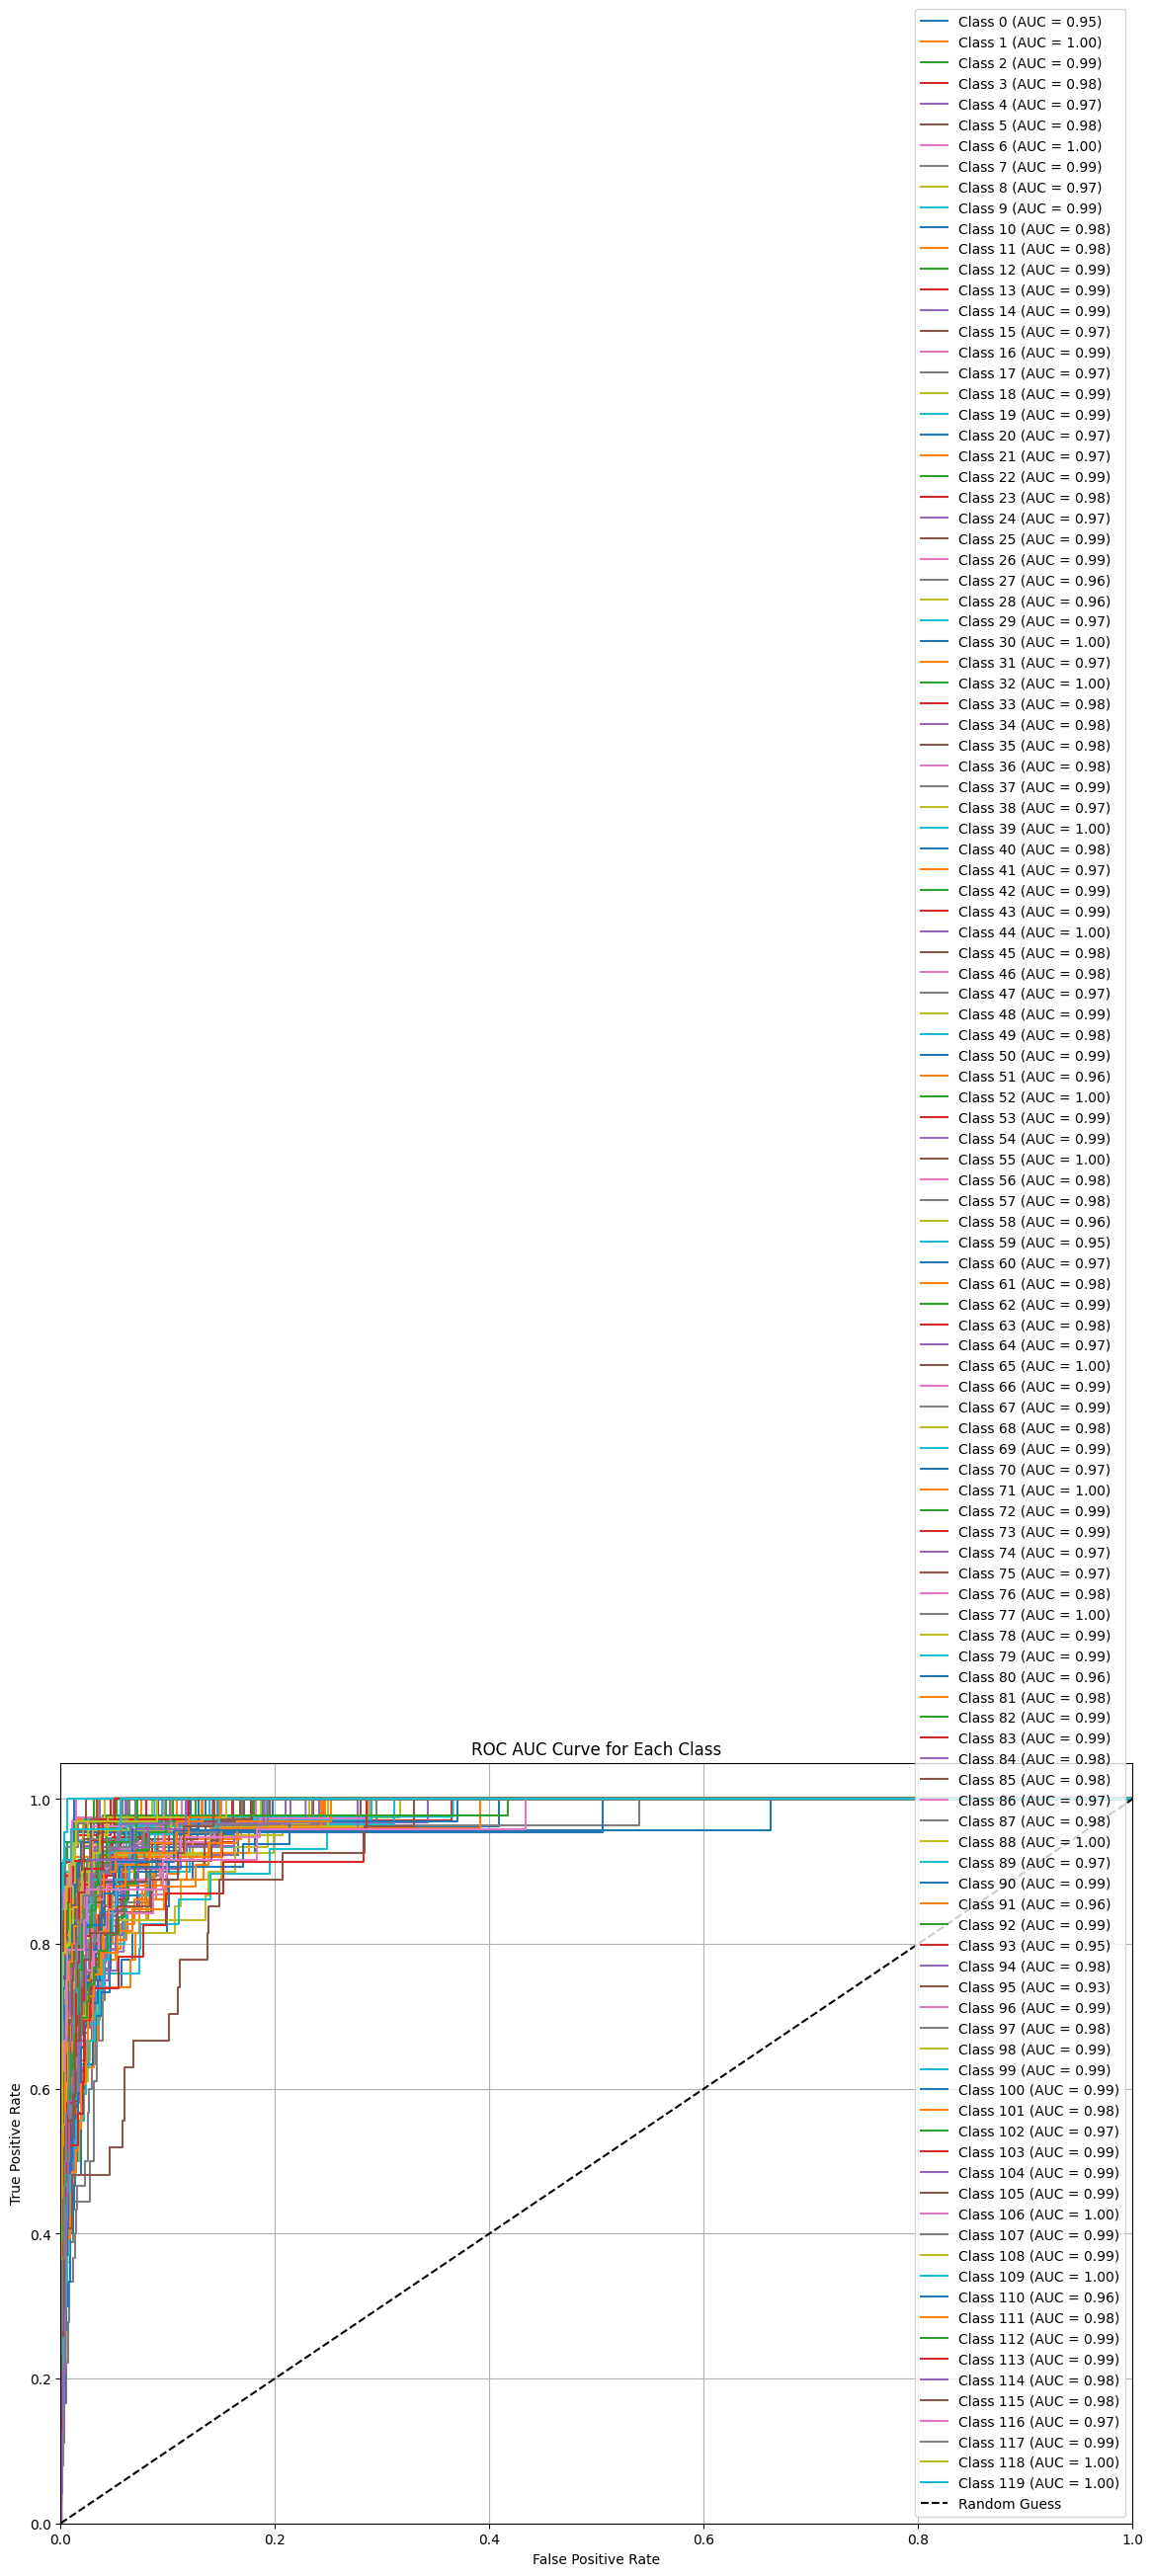

In [44]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC AUC curve for each class
plt.figure(figsize=(14, 10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC AUC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
